In [1]:
import pandas as pd
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
import gfdl_utils as gu
import glob
import re
from scipy.interpolate import griddata
import geopy
import cmocean
import gsw
from geopy import distance
import xesmf as xe
import sectionate
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/src')
from src import *

In [2]:
plotsdir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/figures/" + x
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/data/" + x

In [3]:
def GLODAPP_LON_to_CM4X(lons):
    lons_copy = 1 * lons 
    lons_copy[lons_copy > 60] -= 360
    return lons_copy
def CM4X_LON_to_GLODAPP(lons): 
    lons_copy = 1 * lons 
    lons_copy[(lons_copy > -300) * (lons_copy < -180)] +=360
    return lons_copy

def CM4X_to_reg_grid(ds): 
    xhcopy = 1 * ds.xh.values
    xhcopy[(ds.xh > -300) * (ds.xh < -180)] += 360
    
    ds_copy = 1 * ds
    ds_copy.coords['xh'] = 1 * xhcopy

    return ds_copy.reindex({ "xh" : xhcopy})

def read_CM4X(fname): 
    return xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        chunks={"latitude":-1, "longitude":-1},
        engine="zarr")

def compute_depth_average(ds, zmin, zmax): 
    return ds.sel(zl = slice(zmin, zmax)).mean("zl")

In [4]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='150GB',
    walltime='02:00:00',
    queue='compute',
    interface='ib0')
print(cluster.job_script())
cluster.scale(jobs=16)
from dask.distributed import Client
client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=140G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/bin/python -m distributed.cli.dask_worker tcp://172.16.3.90:39092 --nthreads 36 --memory-limit 139.70GiB --name dummy-name --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.90:39092,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
# GLODAP:model variable naming conventions
model2glodap_names = {'cfc12':'cfc12','cfc11':'cfc11','sf6':'sf6','thetao':'theta','so':'salinity'}
variable_kwargs = {
    'cfc12':{'conversion':1e12/1035,'cmap':'Greens','units':'pmolkg-1'},
    'cfc11':{'conversion':1e12/1035,'cmap':'PuRd','units':'pmolkg-1'},
    'sf6':{'conversion':1e12/1035 * 1e3,'cmap':'Blues','units':'fmolkg-1'},
    'theta':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'degK','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'salinity':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu','bins':np.arange(32,37,0.05),'anombins':np.arange(-1,1.02,0.02)}
}

In [6]:
def read_CM4X(fname): 
    ds = xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        chunks={"latitude":10, "longitude":10, "zl":-1, "year":10},
        engine="zarr")
    
    ds = ds.drop(["lat", "lon"])
    ds = ds.rename({"geolat":"lat", "geolon":"lon"})
    ds = approximate_z(ds)
    # ds = ds.where(ds.thkcello > 1e-9)
    return ds

def compute_depth_average(ds, zmin, zmax): 
    return ds.sel(zl = slice(zmin, zmax)).mean("zl")
ds = read_CM4X(datadir("CM4Xp125_historical_transient_tracers.zarr"))
ds_lo = read_CM4X(datadir("CM4Xp25_historical_transient_tracers.zarr"))

In [7]:
ds_locs = xr.Dataset()
ds_locs["lon"] = xr.DataArray(
    data=np.arange(-299, 59), dims=("locations") #need to regrid within model coordinates
)
ds_locs["lat"] = xr.DataArray(data=np.repeat(-50, len(ds_locs["lon"])), dims=("locations"))

In [8]:
regridder = xe.Regridder(ds, ds_locs[["lon", "lat"]], "bilinear", locstream_out=True, periodic = False)
section_dsm = regridder(ds).compute()
section_dsm["lon"] = ("locations", ds_locs["lon"].values)
section_dsm["lat"] = ("locations", ds_locs["lat"].values)
section_dsm = get_sigma2(section_dsm).compute()


regridder = xe.Regridder(ds_lo, ds_locs[["lon", "lat"]], "bilinear", locstream_out=True, periodic = False)
section_dsm_lo = regridder(ds_lo).compute()
section_dsm_lo["lon"] = ("locations", ds_locs["lon"].values)
section_dsm_lo["lat"] = ("locations", ds_locs["lat"].values)
section_dsm_lo = get_sigma2(section_dsm_lo).compute()

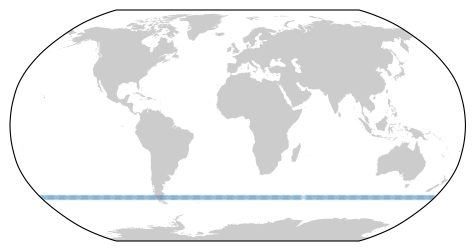

In [9]:
import cartopy.feature as cfeature;

fig,ax=plt.subplots(figsize=(6,3),subplot_kw={'projection':ccrs.Robinson(central_longitude = 0)})
ax.set_global()
# ax.coastlines()
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='grey', alpha = 0.4))

x = CM4X_LON_to_GLODAPP(ds_locs['lon'])
y = ds_locs['lat']
l = ax.scatter(x,y,transform=ccrs.PlateCarree(),marker='.', alpha = 0.1)
# 
# color = l[0].get_color()

In [25]:
section_dsm_lo.sigma2.min(), section_dsm_lo.sigma2.max()

(<xarray.DataArray 'sigma2' ()>
 array(34.40383268),
 <xarray.DataArray 'sigma2' ()>
 array(37.23692937))

In [10]:
new_sigma_grid = np.linspace(section_dsm_lo.sigma2.min(), section_dsm_lo.sigma2.max())
new_sigma_grid

array([34.40383268, 34.46165098, 34.51946928, 34.57728758, 34.63510588,
       34.69292418, 34.75074248, 34.80856078, 34.86637908, 34.92419738,
       34.98201568, 35.03983398, 35.09765228, 35.15547058, 35.21328888,
       35.27110718, 35.32892548, 35.38674378, 35.44456208, 35.50238038,
       35.56019868, 35.61801697, 35.67583527, 35.73365357, 35.79147187,
       35.84929017, 35.90710847, 35.96492677, 36.02274507, 36.08056337,
       36.13838167, 36.19619997, 36.25401827, 36.31183657, 36.36965487,
       36.42747317, 36.48529147, 36.54310977, 36.60092807, 36.65874637,
       36.71656467, 36.77438297, 36.83220127, 36.89001957, 36.94783787,
       37.00565617, 37.06347447, 37.12129277, 37.17911107, 37.23692937])

In [11]:
ds_sections = []
ds_sections_lo = []

for i in range(len(section_dsm.year)):
    if (i %20) == 0:
        print(i)
    tmp1 =  1* interpolate_section(section_dsm[["cfc11", "cfc12", "sf6", "sigma2", "thkcello", "z", "thetao"]].isel(year = i).compute(),
                                 new_sigma_grid, 
                                interp_coord = "sigma2",iterate_coord =  "locations", kind = "linear")
    ds_sections = ds_sections + [tmp1]
    #now do lo-res
    tmp2 =  1* interpolate_section(section_dsm_lo[["cfc11", "cfc12", "sf6", "sigma2", "thkcello", "z", "thetao"]].isel(year = i).compute(),
                                 new_sigma_grid, 
                                interp_coord = "sigma2",iterate_coord =  "locations", kind = "linear")
    ds_sections_lo = ds_sections_lo + [tmp2]
    
ds_section = xr.concat(ds_sections, dim = "year")
ds_section["year"] = section_dsm.year

ds_section_lo = xr.concat(ds_sections_lo, dim = "year")
ds_section_lo["year"] = section_dsm_lo.year

0
20
40
60
80
100
120
140
160


In [12]:
def make_float(num):
    num = num.replace(' ','').replace(',','.').replace("−", "-")
    return float(num)


/tmp/ipykernel_193096/1134701920.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  [a.set_xticklabels(labels) for a in ax]


[Text(0, 0.5, '$\\sigma_2$'),
 Text(0, 0.5, '$\\sigma_2$'),
 Text(0, 0.5, '$\\sigma_2$')]

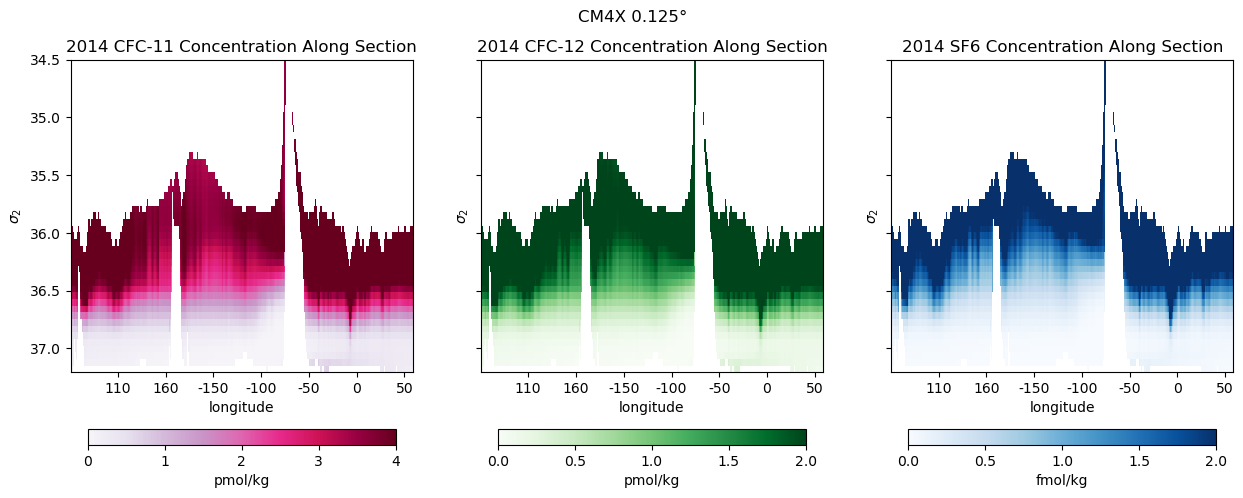

In [13]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5), sharey = True)


cm = ax[0].pcolormesh(ds_locs['lon'], ds_section.sigma2, 
                 ds_section.cfc11.isel(year = -1) * variable_kwargs["cfc11"]["conversion"], 
                 vmin = 0, vmax  = 4, cmap = variable_kwargs["cfc11"]["cmap"])
fig.colorbar(cm, ax = ax[0], orientation = "horizontal", fraction = 0.04, label= "pmol/kg")

ax[0].set_title("2014 CFC-11 Concentration Along Section")
cm = ax[1].pcolormesh(ds_locs['lon'], ds_section.sigma2, 
                 ds_section.cfc12.isel(year = -1) * variable_kwargs["cfc12"]["conversion"], 
                 vmin = 0, vmax  = 2, cmap = variable_kwargs["cfc12"]["cmap"])

fig.colorbar(cm, ax = ax[1], orientation = "horizontal", fraction = 0.04, label= "pmol/kg")
ax[1].set_title("2014 CFC-12 Concentration Along Section")

cm = ax[2].pcolormesh(ds_locs['lon'], ds_section.sigma2, 
                 ds_section.sf6.isel(year = -1) * variable_kwargs["sf6"]["conversion"], 
                 vmin = 0, vmax  = 2, cmap = variable_kwargs["sf6"]["cmap"])
fig.colorbar(cm, ax = ax[2], orientation = "horizontal", fraction = 0.04, label= "fmol/kg")

ax[2].set_title("2014 SF6 Concentration Along Section")

[a.set_ylim(34.5, 37.2) for a in ax]
[a.invert_yaxis() for a in ax]
fig.suptitle("CM4X 0.125°")
labels = [item.get_text() for item in ax[0].get_xticklabels()]
labels = np.array([make_float(l) for l in labels])
labels = CM4X_LON_to_GLODAPP(labels)
labels = labels.astype(int).astype(str)

[a.set_xticklabels(labels) for a in ax]

[a.set_xlabel("longitude") for a in ax]
[a.set_ylabel(r"$\sigma_2$") for a in ax]


/tmp/ipykernel_193096/1742066708.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  [a.set_xticklabels(labels) for a in ax]


Text(0.5, 0.98, 'CM4X 0.25°')

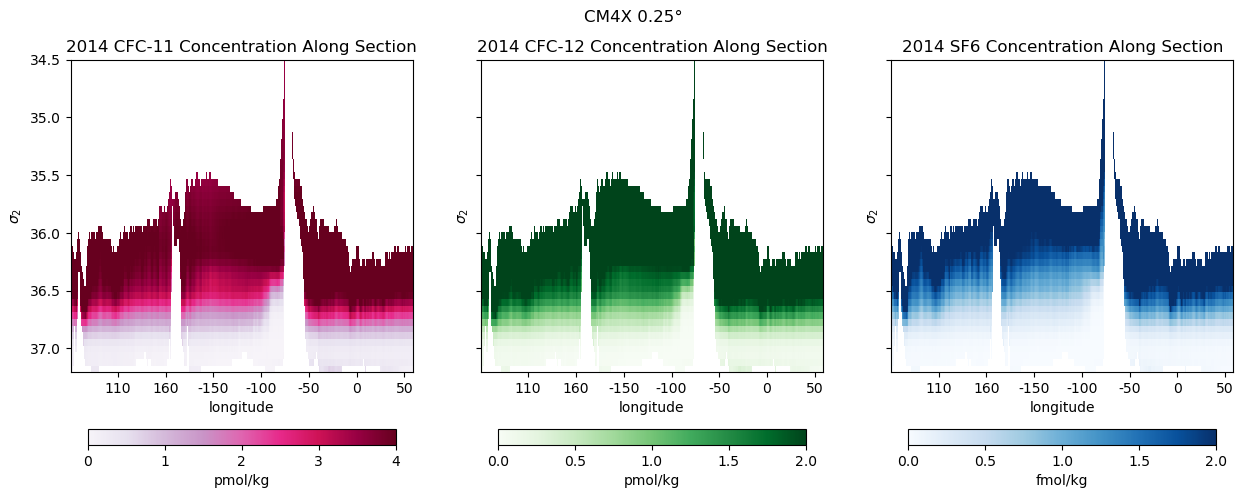

In [14]:
#now plotting for low-res
fig, ax = plt.subplots(1, 3, figsize = (15, 5), sharey = True)


cm = ax[0].pcolormesh(ds_locs['lon'], ds_section_lo.sigma2, 
                 ds_section_lo.cfc11.isel(year = -1) * variable_kwargs["cfc11"]["conversion"], 
                 vmin = 0, vmax  = 4, cmap = variable_kwargs["cfc11"]["cmap"])
fig.colorbar(cm, ax = ax[0], orientation = "horizontal", fraction = 0.04, label= "pmol/kg")

ax[0].set_title("2014 CFC-11 Concentration Along Section")
cm = ax[1].pcolormesh(ds_locs['lon'], ds_section_lo.sigma2, 
                 ds_section_lo.cfc12.isel(year = -1) * variable_kwargs["cfc12"]["conversion"], 
                 vmin = 0, vmax  = 2, cmap = variable_kwargs["cfc12"]["cmap"])

fig.colorbar(cm, ax = ax[1], orientation = "horizontal", fraction = 0.04, label= "pmol/kg")
ax[1].set_title("2014 CFC-12 Concentration Along Section")

cm = ax[2].pcolormesh(ds_locs['lon'], ds_section_lo.sigma2, 
                 ds_section_lo.sf6.isel(year = -1) * variable_kwargs["sf6"]["conversion"], 
                 vmin = 0, vmax  = 2, cmap = variable_kwargs["sf6"]["cmap"])
fig.colorbar(cm, ax = ax[2], orientation = "horizontal", fraction = 0.04, label= "fmol/kg")

ax[2].set_title("2014 SF6 Concentration Along Section")

labels = [item.get_text() for item in ax[0].get_xticklabels()]
labels = np.array([make_float(l) for l in labels])
labels = CM4X_LON_to_GLODAPP(labels)
labels = labels.astype(int).astype(str)
[a.set_xticklabels(labels) for a in ax]

[a.set_ylim(34.5, 37.2) for a in ax]
[a.invert_yaxis() for a in ax]
[a.set_xlabel("longitude") for a in ax]
[a.set_ylabel(r"$\sigma_2$") for a in ax]
fig.suptitle("CM4X 0.25°")

In [15]:
mean_ds = (ds_section * ds_section.thkcello).sum("locations") / ds_section.thkcello.sum("locations")
mean_ds["thkcello"] = ds_section["thkcello"].mean("locations")
mean_ds["year"]= section_dsm.year

mean_ds_lo = (ds_section_lo * ds_section_lo.thkcello).sum("locations") / ds_section_lo.thkcello.sum("locations")
mean_ds_lo["thkcello"] = ds_section_lo["thkcello"].mean("locations")
mean_ds_lo["year"]= section_dsm_lo.year

In [16]:
def derivative(ds):
    return ds.values[1:, :] - ds.values[:-1, :]

Text(0.5, 0.98, 'Average Concentration CM4X 0.125°')

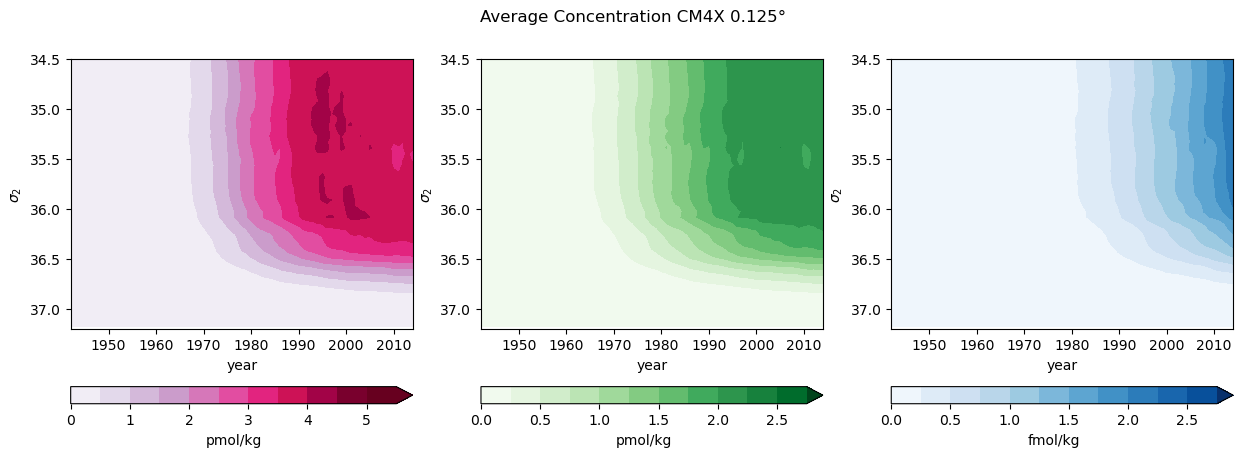

In [17]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

cm = ax[0].contourf(mean_ds.year, mean_ds.sigma2, mean_ds.cfc11.T * variable_kwargs["cfc11"]["conversion"], 
               cmap = variable_kwargs["cfc11"]["cmap"], vmin = 0, vmax = 5, levels = np.arange(0, 6, 0.5), extend = "max")
fig.colorbar(cm, ax = ax[0], orientation = "horizontal", label = "pmol/kg")

cm = ax[1].contourf(mean_ds.year, mean_ds.sigma2, mean_ds.cfc12.T * variable_kwargs["cfc12"]["conversion"], 
               cmap = variable_kwargs["cfc12"]["cmap"], vmin = 0, vmax = 3, levels = np.arange(0, 3, 0.25), extend = "max")
fig.colorbar(cm, ax = ax[1], orientation = "horizontal", label = "pmol/kg")

cm = ax[2].contourf(mean_ds.year, mean_ds.sigma2, mean_ds.sf6.T * variable_kwargs["sf6"]["conversion"], 
               cmap = variable_kwargs["sf6"]["cmap"], vmin = 0, vmax = 3, levels = np.arange(0, 3, 0.25), extend = "max")
fig.colorbar(cm, ax = ax[2], orientation = "horizontal", label = "fmol/kg")

[a.set_ylabel(r"$\sigma_2$") for a in ax]
[a.set_xlabel("year") for a in ax]
[a.set_ylim(34.5, 37.2) for a in ax]
[a.set_xlim(1942, 2014) for a in ax]
[a.invert_yaxis() for a in ax]
fig.suptitle("Average Concentration CM4X 0.125°")

Text(0.5, 0.98, 'Average Concentration CM4X 0.25°')

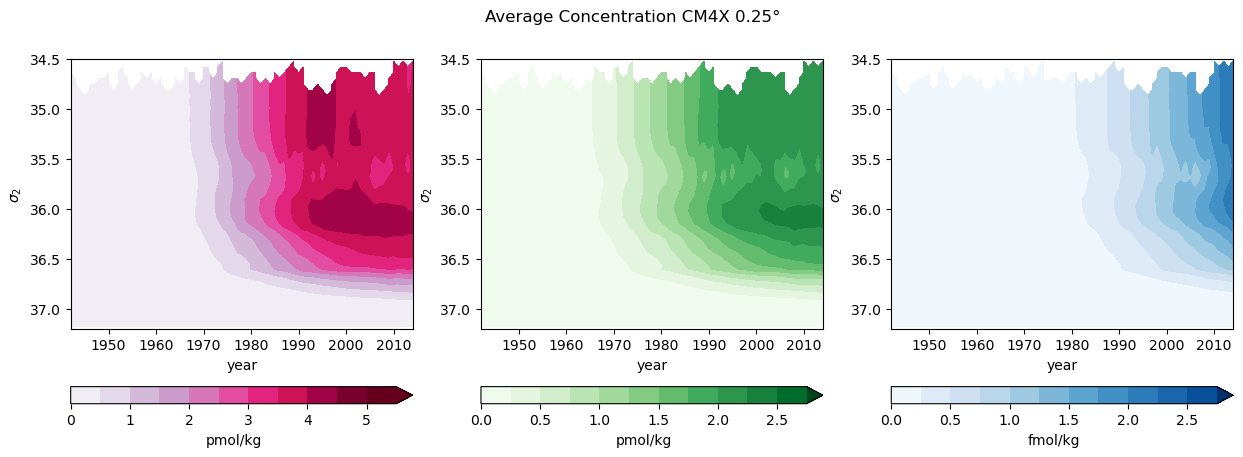

In [18]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

cm = ax[0].contourf(mean_ds_lo.year, mean_ds_lo.sigma2, mean_ds_lo.cfc11.T * variable_kwargs["cfc11"]["conversion"], 
               cmap = variable_kwargs["cfc11"]["cmap"], vmin = 0, vmax = 5, levels = np.arange(0, 6, 0.5), extend = "max")
fig.colorbar(cm, ax = ax[0], orientation = "horizontal", label = "pmol/kg")

cm = ax[1].contourf(mean_ds_lo.year, mean_ds_lo.sigma2, mean_ds_lo.cfc12.T * variable_kwargs["cfc12"]["conversion"], 
               cmap = variable_kwargs["cfc12"]["cmap"], vmin = 0, vmax = 3, levels = np.arange(0, 3, 0.25), extend = "max")
fig.colorbar(cm, ax = ax[1], orientation = "horizontal", label = "pmol/kg")

cm = ax[2].contourf(mean_ds_lo.year, mean_ds_lo.sigma2, mean_ds_lo.sf6.T * variable_kwargs["sf6"]["conversion"], 
               cmap = variable_kwargs["sf6"]["cmap"], vmin = 0, vmax = 3, levels = np.arange(0, 3, 0.25), extend = "max")
fig.colorbar(cm, ax = ax[2], orientation = "horizontal", label = "fmol/kg")

[a.set_ylabel(r"$\sigma_2$") for a in ax]
[a.set_xlabel("year") for a in ax]
[a.set_ylim(34.5, 37.2) for a in ax]
[a.set_xlim(1942, 2014) for a in ax]
[a.invert_yaxis() for a in ax]
fig.suptitle("Average Concentration CM4X 0.25°")

Text(0.5, 0.98, 'd(Concentraton)/dt CM4X 0.25°')

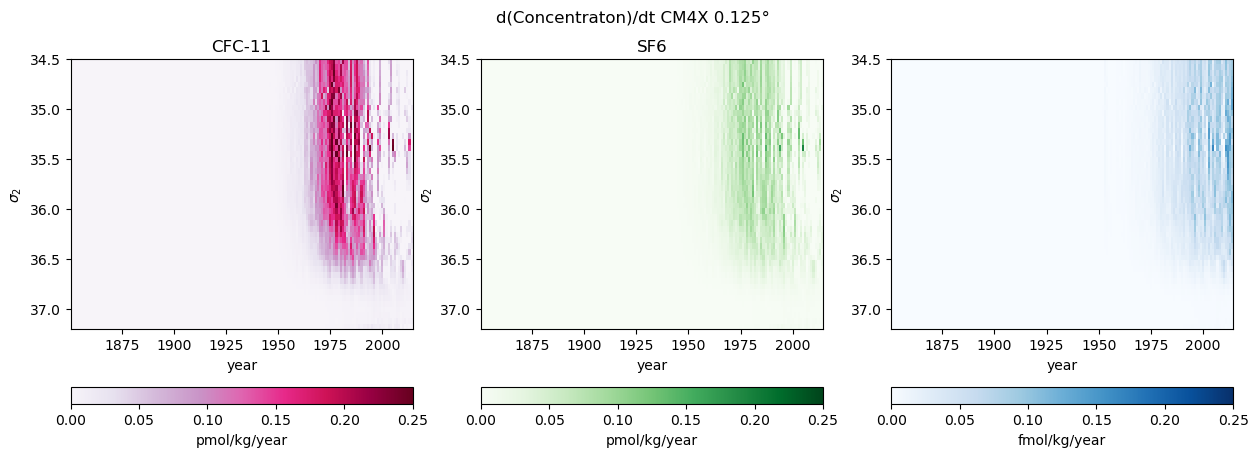

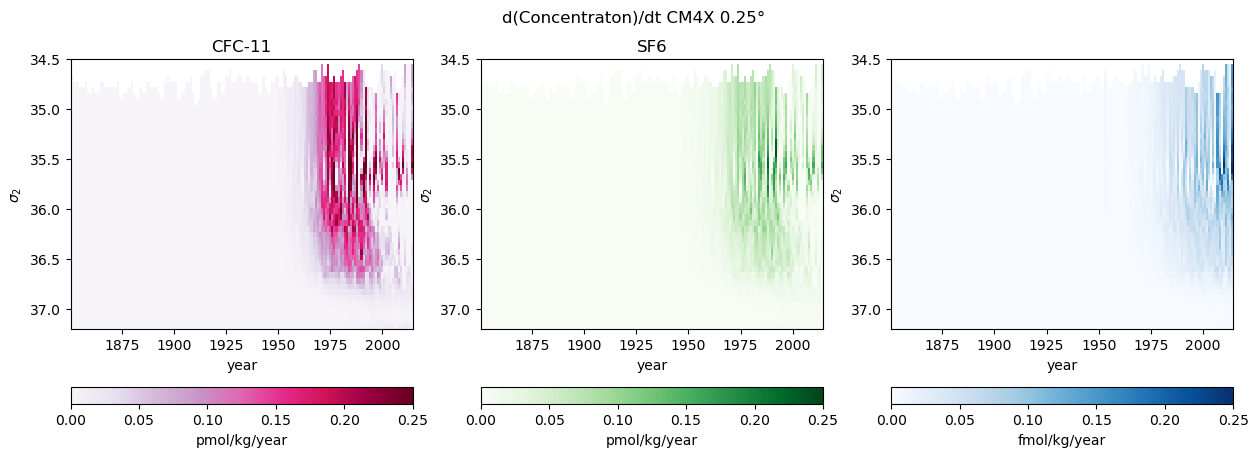

In [19]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

cm = ax[0].pcolormesh(mean_ds.year[1:], mean_ds.sigma2, derivative(mean_ds.cfc11).T * variable_kwargs["cfc11"]["conversion"], 
               cmap = variable_kwargs["cfc11"]["cmap"], vmin = 0, vmax = .25)
fig.colorbar(cm, ax = ax[0], orientation = "horizontal", label = "pmol/kg/year")
ax[0].set_title("CFC-11")
cm = ax[1].pcolormesh(mean_ds.year[1:], mean_ds.sigma2, derivative(mean_ds.cfc12).T * variable_kwargs["cfc12"]["conversion"], 
               cmap = variable_kwargs["cfc12"]["cmap"], vmin = 0, vmax = .25)
fig.colorbar(cm, ax = ax[1], orientation = "horizontal", label = "pmol/kg/year")
ax[1].set_title("CFC-12")

cm = ax[2].pcolormesh(mean_ds.year[1:], mean_ds.sigma2, derivative(mean_ds.sf6).T * variable_kwargs["sf6"]["conversion"], 
               cmap = variable_kwargs["sf6"]["cmap"], vmin = 0, vmax = .25)
ax[1].set_title("SF6")

fig.colorbar(cm, ax = ax[2], orientation = "horizontal", label = "fmol/kg/year")


[a.set_ylim(34.5, 37.2) for a in ax]
# [a.set_xlim(1942, 2015) for a in ax]
[a.invert_yaxis() for a in ax]
[a.set_ylabel(r"$\sigma_2$") for a in ax]
[a.set_xlabel("year") for a in ax]

fig.suptitle("d(Concentraton)/dt CM4X 0.125°")


fig, ax = plt.subplots(1, 3, figsize = (15, 5))

cm = ax[0].pcolormesh(mean_ds_lo.year[1:], mean_ds_lo.sigma2, derivative(mean_ds_lo.cfc11).T * variable_kwargs["cfc11"]["conversion"], 
               cmap = variable_kwargs["cfc11"]["cmap"], vmin = 0, vmax = .25)
fig.colorbar(cm, ax = ax[0], orientation = "horizontal", label = "pmol/kg/year")
ax[0].set_title("CFC-11")

cm = ax[1].pcolormesh(mean_ds_lo.year[1:], mean_ds_lo.sigma2, derivative(mean_ds_lo.cfc12).T * variable_kwargs["cfc12"]["conversion"], 
               cmap = variable_kwargs["cfc12"]["cmap"], vmin = 0, vmax = .25)
fig.colorbar(cm, ax = ax[1], orientation = "horizontal", label = "pmol/kg/year")
ax[1].set_title("CFC-12")

cm = ax[2].pcolormesh(mean_ds_lo.year[1:], mean_ds_lo.sigma2, derivative(mean_ds_lo.sf6).T * variable_kwargs["sf6"]["conversion"], 
               cmap = variable_kwargs["sf6"]["cmap"], vmin = 0, vmax = .25)
fig.colorbar(cm, ax = ax[2], orientation = "horizontal", label = "fmol/kg/year")
ax[1].set_title("SF6")

[a.set_ylabel(r"$\sigma_2$") for a in ax]
[a.set_xlabel("year") for a in ax]
[a.set_ylim(34.5, 37.2) for a in ax]
[a.invert_yaxis() for a in ax]
fig.suptitle("d(Concentraton)/dt CM4X 0.25°")

Text(0.5, 0.98, 'CM4X 0.25°')

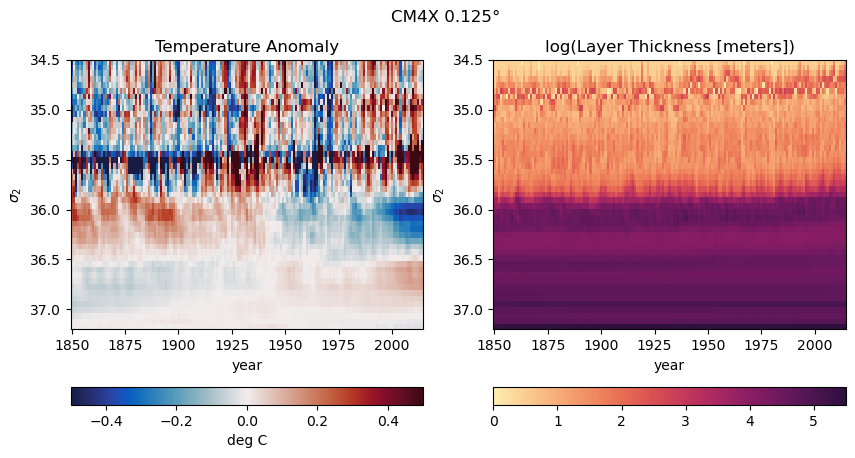

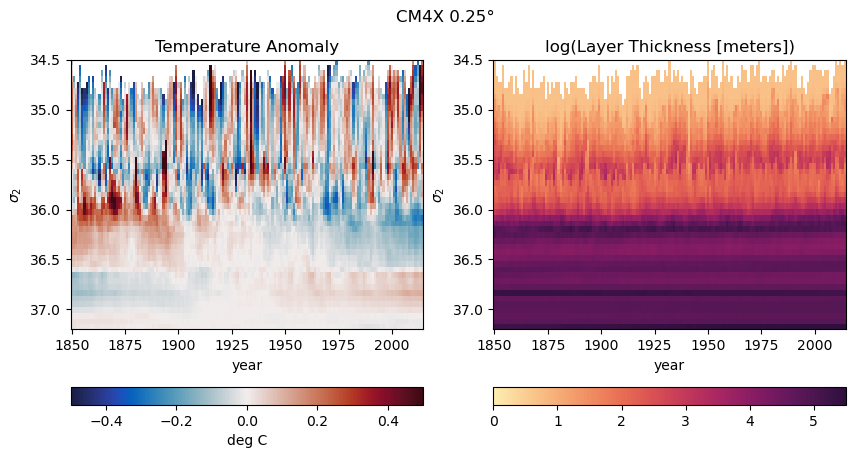

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))

cm = ax[0].pcolormesh(mean_ds.year, mean_ds.sigma2, (mean_ds.thetao - mean_ds.thetao.mean("year")).T, 
               cmap = cmocean.cm.balance, vmin = -0.5, vmax = 0.5)
fig.colorbar(cm, ax = ax[0], orientation = "horizontal", label = "deg C")
cm = ax[1].pcolormesh(mean_ds.year, mean_ds.sigma2,  np.log(mean_ds.thkcello).T, 
               cmap = cmocean.cm.matter, vmin = 0, vmax = 5.5)
fig.colorbar(cm, ax = ax[1], orientation = "horizontal", label = "")

[a.set_ylim(34.5, 37.2) for a in ax]
# [a.set_xlim(1942, 2015) for a in ax]
[a.invert_yaxis() for a in ax]
ax[0].set_ylabel(r"$\sigma_2$")
ax[1].set_ylabel(r"$\sigma_2$")
ax[0].set_xlabel("year")
ax[1].set_xlabel("year")
ax[0].set_title("Temperature Anomaly")
ax[1].set_title("log(Layer Thickness [meters])")
fig.suptitle("CM4X 0.125°")


fig, ax = plt.subplots(1, 2, figsize = (10, 5))

cm = ax[0].pcolormesh(mean_ds_lo.year, mean_ds_lo.sigma2, (mean_ds_lo.thetao - mean_ds_lo.thetao.mean("year")).T, 
               cmap = cmocean.cm.balance, vmin = -0.5, vmax = 0.5)
fig.colorbar(cm, ax = ax[0], orientation = "horizontal", label = "deg C")
cm = ax[1].pcolormesh(mean_ds_lo.year, mean_ds_lo.sigma2,  np.log(mean_ds_lo.thkcello).T, 
               cmap = cmocean.cm.matter, vmin = 0, vmax = 5.5)
fig.colorbar(cm, ax = ax[1], orientation = "horizontal", label = "")

[a.set_ylim(34.5, 37.2) for a in ax]
# [a.set_xlim(1942, 2015) for a in ax]
[a.invert_yaxis() for a in ax]
ax[0].set_ylabel(r"$\sigma_2$")
ax[1].set_ylabel(r"$\sigma_2$")
ax[0].set_xlabel("year")
ax[1].set_xlabel("year")
ax[0].set_title("Temperature Anomaly")
ax[1].set_title("log(Layer Thickness [meters])")
fig.suptitle("CM4X 0.25°")

In [21]:
def compute_concentration(ds, varn, sigma = 36.75): 
    cfc = ds.sel(sigma2 = 36.75, method = "nearest")[varn]
    cfc = cfc* variable_kwargs[varn]["conversion"]
    return cfc
def derivative2(ds):
    return (ds.values[2:] - ds.values[:-2]) / 2

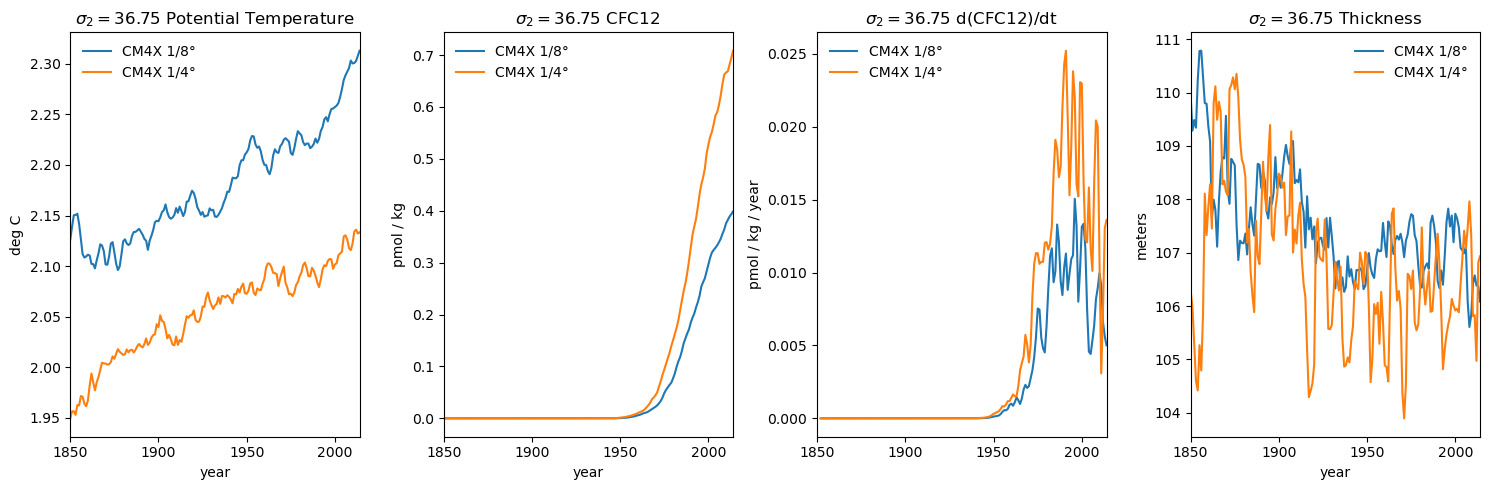

In [22]:
fig, ax = plt.subplots(1, 4, figsize = (15, 5))

mean_ds.sel(sigma2 = 36.75, method = "nearest").thetao.plot(ax = ax[0], label = "CM4X 1/8°"); 
mean_ds_lo.sel(sigma2 = 36.75, method = "nearest").thetao.plot(ax = ax[0], label = "CM4X 1/4°"); 
ax[0].set_title(r"$\sigma_2 = 36.75$" + " Potential Temperature")

cfc = compute_concentration(mean_ds, "cfc12", sigma =  36.75)
cfc_lo = compute_concentration(mean_ds_lo, "cfc12", sigma =  36.75)
cfc.plot(ax = ax[1], label = "CM4X 1/8°"); 
cfc_lo.plot(ax = ax[1], label = "CM4X 1/4°"); 
ax[1].set_title(r"$\sigma_2 = 36.75$" + " CFC12 ")

ax[2].plot(section_dsm.year[2:], derivative2(cfc), label = "CM4X 1/8°"); 
ax[2].plot(section_dsm.year[2:], derivative2(cfc_lo), label = "CM4X 1/4°"); 
ax[2].set_title(r"$\sigma_2 = 36.75$" + " d(CFC12)/dt ")


mean_ds.sel(sigma2 = 36.75, method = "nearest").thkcello.plot(ax = ax[3], label = "CM4X 1/8°"); 
mean_ds_lo.sel(sigma2 = 36.75, method = "nearest").thkcello.plot(ax = ax[3], label = "CM4X 1/4°"); 
ax[3].set_title(r"$\sigma_2 = 36.75$" + " Thickness")

ax[0].set_ylabel("deg C")
ax[1].set_ylabel("pmol / kg")
ax[2].set_ylabel("pmol / kg / year")

ax[3].set_ylabel("meters")      
[a.set_xlim(1850, 2014) for a in ax]
[a.legend(frameon = False) for a in ax]
fig.tight_layout()

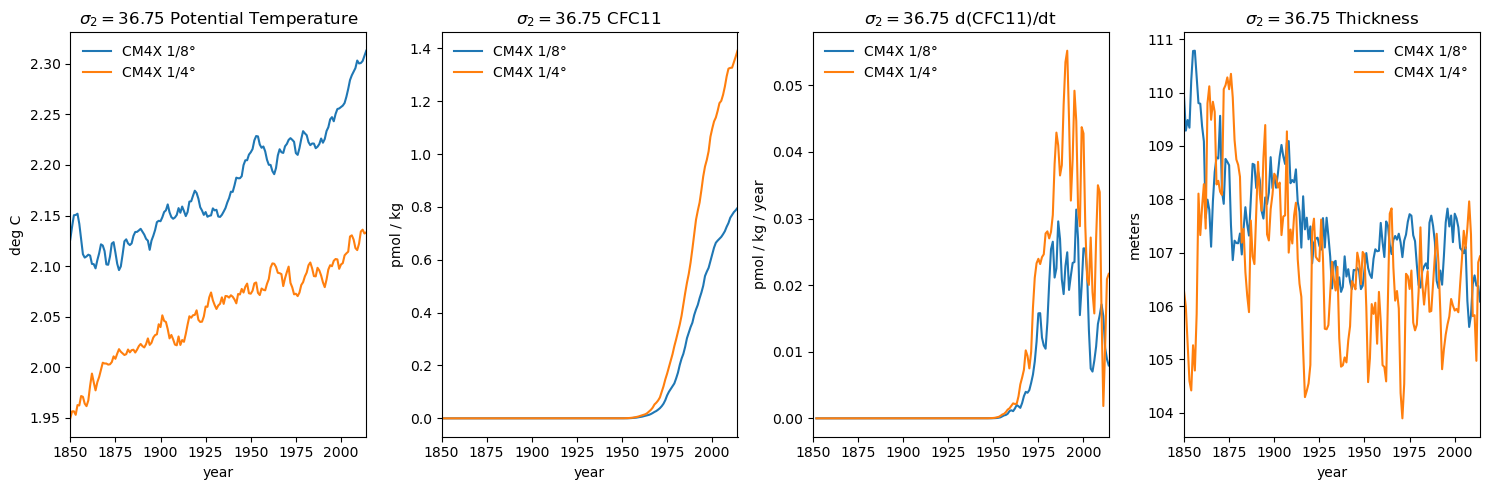

In [23]:
fig, ax = plt.subplots(1, 4, figsize = (15, 5))

mean_ds.sel(sigma2 = 36.75, method = "nearest").thetao.plot(ax = ax[0], label = "CM4X 1/8°"); 
mean_ds_lo.sel(sigma2 = 36.75, method = "nearest").thetao.plot(ax = ax[0], label = "CM4X 1/4°"); 
ax[0].set_title(r"$\sigma_2 = 36.75$" + " Potential Temperature")

varn = "cfc11"; varnl = " CFC11 "
cfc = compute_concentration(mean_ds, varn, sigma =  36.75)
cfc_lo = compute_concentration(mean_ds_lo, varn, sigma =  36.75)
cfc.plot(ax = ax[1], label = "CM4X 1/8°"); 
cfc_lo.plot(ax = ax[1], label = "CM4X 1/4°"); 
ax[1].set_title(r"$\sigma_2 = 36.75$" + varnl)

varnl =" d(CFC11)/dt "
ax[2].plot(section_dsm.year[2:], derivative2(cfc), label = "CM4X 1/8°"); 
ax[2].plot(section_dsm.year[2:], derivative2(cfc_lo), label = "CM4X 1/4°"); 
ax[2].set_title(r"$\sigma_2 = 36.75$" + varnl)

mean_ds.sel(sigma2 = 36.75, method = "nearest").thkcello.plot(ax = ax[3], label = "CM4X 1/8°"); 
mean_ds_lo.sel(sigma2 = 36.75, method = "nearest").thkcello.plot(ax = ax[3], label = "CM4X 1/4°"); 
ax[3].set_title(r"$\sigma_2 = 36.75$" + " Thickness")

ax[0].set_ylabel("deg C")
ax[1].set_ylabel("pmol / kg")
ax[2].set_ylabel("pmol / kg / year")

ax[3].set_ylabel("meters")      
[a.set_xlim(1850, 2014) for a in ax]
[a.legend(frameon = False) for a in ax]
fig.tight_layout()

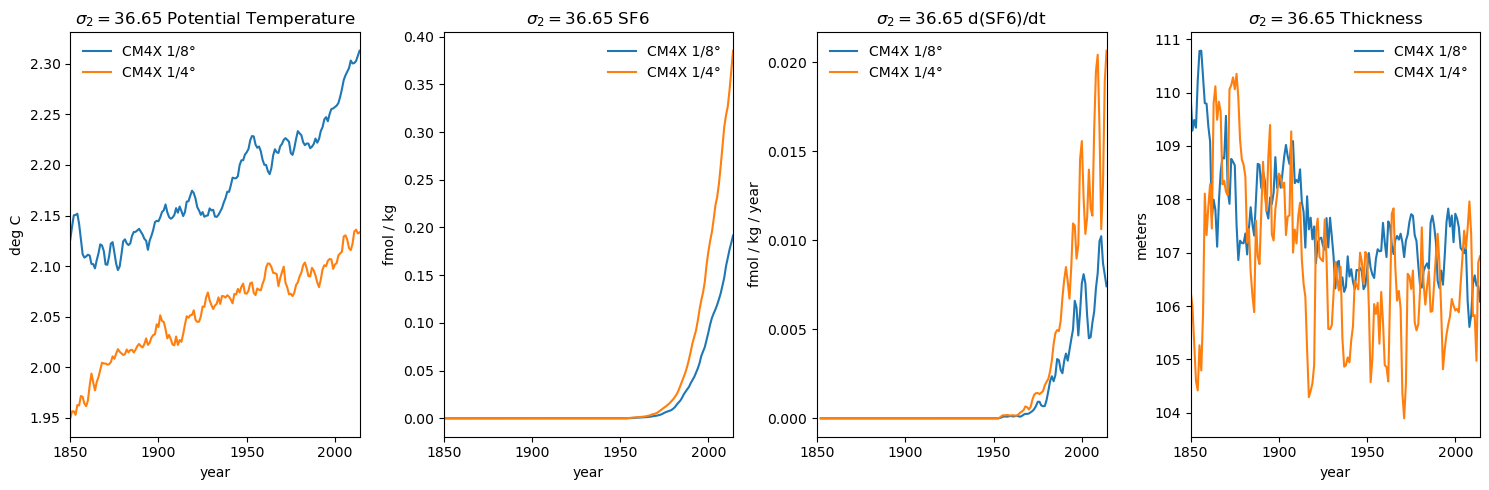

In [24]:
fig, ax = plt.subplots(1, 4, figsize = (15, 5))

mean_ds.sel(sigma2 = 36.75, method = "nearest").thetao.plot(ax = ax[0], label = "CM4X 1/8°"); 
mean_ds_lo.sel(sigma2 = 36.75, method = "nearest").thetao.plot(ax = ax[0], label = "CM4X 1/4°"); 
ax[0].set_title(r"$\sigma_2 = 36.65$" + " Potential Temperature")

varn = "sf6"; varnl = " SF6 "
cfc = compute_concentration(mean_ds, varn, sigma =  36.75)
cfc_lo = compute_concentration(mean_ds_lo, varn, sigma =  36.75)
cfc.plot(ax = ax[1], label = "CM4X 1/8°"); 
cfc_lo.plot(ax = ax[1], label = "CM4X 1/4°"); 
ax[1].set_title(r"$\sigma_2 = 36.65$" + varnl)

varnl =" d(SF6)/dt "
ax[2].plot(section_dsm.year[2:], derivative2(cfc), label = "CM4X 1/8°"); 
ax[2].plot(section_dsm.year[2:], derivative2(cfc_lo), label = "CM4X 1/4°"); 
ax[2].set_title(r"$\sigma_2 = 36.65$" + varnl)

mean_ds.sel(sigma2 = 36.75, method = "nearest").thkcello.plot(ax = ax[3], label = "CM4X 1/8°"); 
mean_ds_lo.sel(sigma2 = 36.75, method = "nearest").thkcello.plot(ax = ax[3], label = "CM4X 1/4°"); 
ax[3].set_title(r"$\sigma_2 = 36.65$" + " Thickness")

ax[0].set_ylabel("deg C")
ax[1].set_ylabel("fmol / kg")
ax[2].set_ylabel("fmol / kg / year")

ax[3].set_ylabel("meters")      
[a.set_xlim(1850, 2014) for a in ax]
[a.legend(frameon = False) for a in ax]
fig.tight_layout()

In [ ]:
ds = pd.read_csv(datadir('mf_CFC-11_obs.csv'), skiprows = 3)
times = ds.iloc[:, 0]
cfcs = np.float32(ds.iloc[:, 1])

In [ ]:
dtimes = (times.values[1:] + times.values[:-1]) / 2

In [ ]:
dt = times.values[1:] - times.values[:-1]
dcfcs = cfcs[1:] - cfcs[:-1]

In [ ]:
import numpy as np
from scipy import interpolate
def fill_nan(A):
    '''
    interpolate to fill nan values
    '''
    inds = np.arange(A.shape[0])
    good = np.where(np.isfinite(A))
    f = interpolate.interp1d(inds[good], A[good],bounds_error=False)
    B = np.where(np.isfinite(A),A,f(inds))
    return B

In [ ]:
import numpy as np
from scipy.signal import butter, lfilter, freqz, filtfilt
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y


# Filter requirements.
order = 2
fs = 12       # sample rate, Hz
cutoff = 1/(12 * 1)  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)


(1950.0, 2014.0)

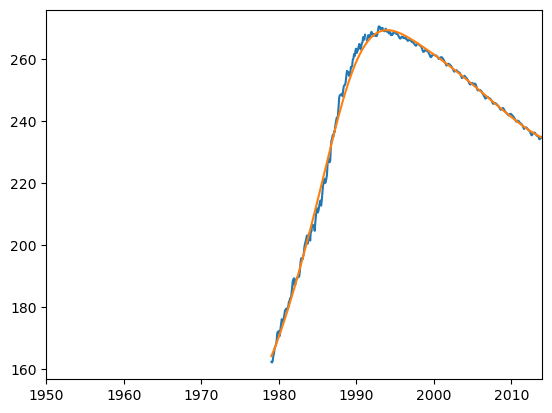

In [ ]:
plt.plot(times, cfcs)
y = butter_lowpass_filter(fill_nan(cfcs)[:-7], 1/12, 12, 2)
plt.plot(times[:-7],y)
plt.xlim(1950, 2014)


(1950.0, 2014.0)

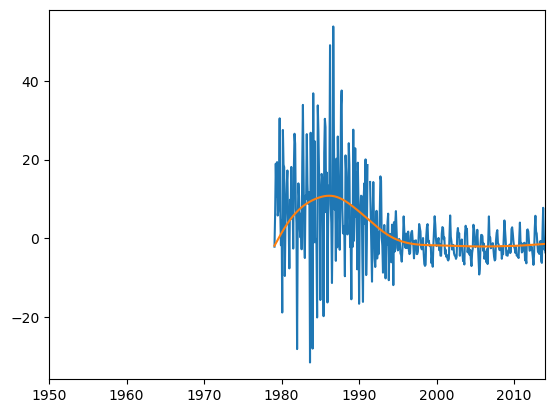

In [ ]:
plt.plot(dtimes, dcfcs / dt)
y = butter_lowpass_filter(fill_nan(dcfcs / dt)[:-7], 1/12, 12, 2)
plt.plot(dtimes[:-7],y)
plt.xlim(1950, 2014)


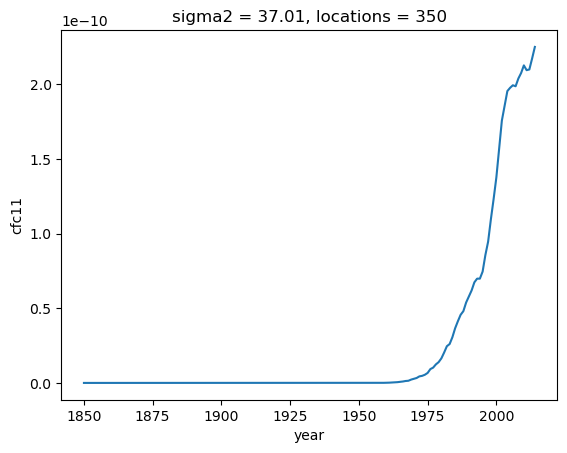

2024-04-05 23:15:29,891 - distributed.batched - INFO - Batched Comm Closed <TCP (closed)  local=tcp://172.16.3.67:39382 remote=tcp://172.16.3.67:59012>
Traceback (most recent call last):
  File "/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/lib/python3.10/site-packages/distributed/batched.py", line 115, in _background_send
    nbytes = yield coro
  File "/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/lib/python3.10/site-packages/tornado/gen.py", line 767, in run
    value = future.result()
  File "/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/lib/python3.10/site-packages/distributed/comm/tcp.py", line 269, in write
    raise CommClosedError()
distributed.comm.core.CommClosedError


In [ ]:
cfc11 = ds_section.sel(sigma2 = 37., locations = 350, method = "nearest").cfc11
cfc11.plot()

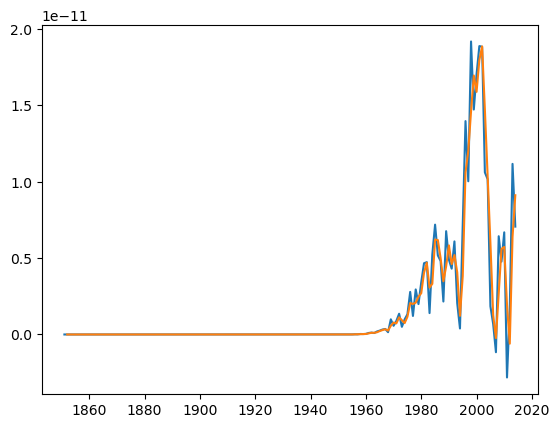

In [ ]:
dcfc11 = cfc11.values[1:] - cfc11.values[:-1]
plt.plot(cfc11.year[1:], dcfc11)

dcfc11 = cfc11.values[2:] - cfc11.values[:-2]
plt.plot(cfc11.year[2:], dcfc11 / 2)